# Processing of data in first flight at 50 meters

In [16]:
from aux.gpx_read import *
from aux.imu_read import *
from aux.lidar_read import *
from aux.navsat_read import *
from aux.px4_read import *
from aux.rosbag_aux import *
from aux.srr308_read import *

import datetime

folder_path = 'data/50m_1'
db3_reader = get_db3_reader(folder_path, 'ROSBAG*')
db3_px4_reader = get_db3_reader(folder_path, 'sensor_bag*')

first_sample = 0
last_sample = 500

radar_df = get_srr308_pointcloud_df_from_db3_reader(db3_reader)
lidar_df = get_lidar_df_from_db3_reader(db3_reader)

first_timestamp = radar_df['timestamp_sample'][first_sample]
print("First timestamp", datetime.datetime.fromtimestamp(first_timestamp).isoformat())


Found ROS 2 bag: data/50m_1/ROSBAG_2025-04-28_12-21-24.378/ROSBAG_2025-04-28_12-21-24.378_0.db3
Found ROS 2 bag: data/50m_1/sensor_bag_20250428_122123/sensor_bag_20250428_122123_0.db3


[INFO] [1746011741.530996909] [rosbag2_storage]: Opened database 'data/50m_1/ROSBAG_2025-04-28_12-21-24.378/ROSBAG_2025-04-28_12-21-24.378_0.db3' for READ_ONLY.
[INFO] [1746011741.793650821] [rosbag2_storage]: Opened database 'data/50m_1/sensor_bag_20250428_122123/sensor_bag_20250428_122123_0.db3' for READ_ONLY.


First timestamp 2025-04-28T12:21:17.389383


In [17]:
lidar_altitude = get_altitude_from_lidar_pc(lidar_df['np_points'], (0,0), 5)
radar_altitude = get_altitude_from_radar_pc(radar_df['points'], 0, 5)

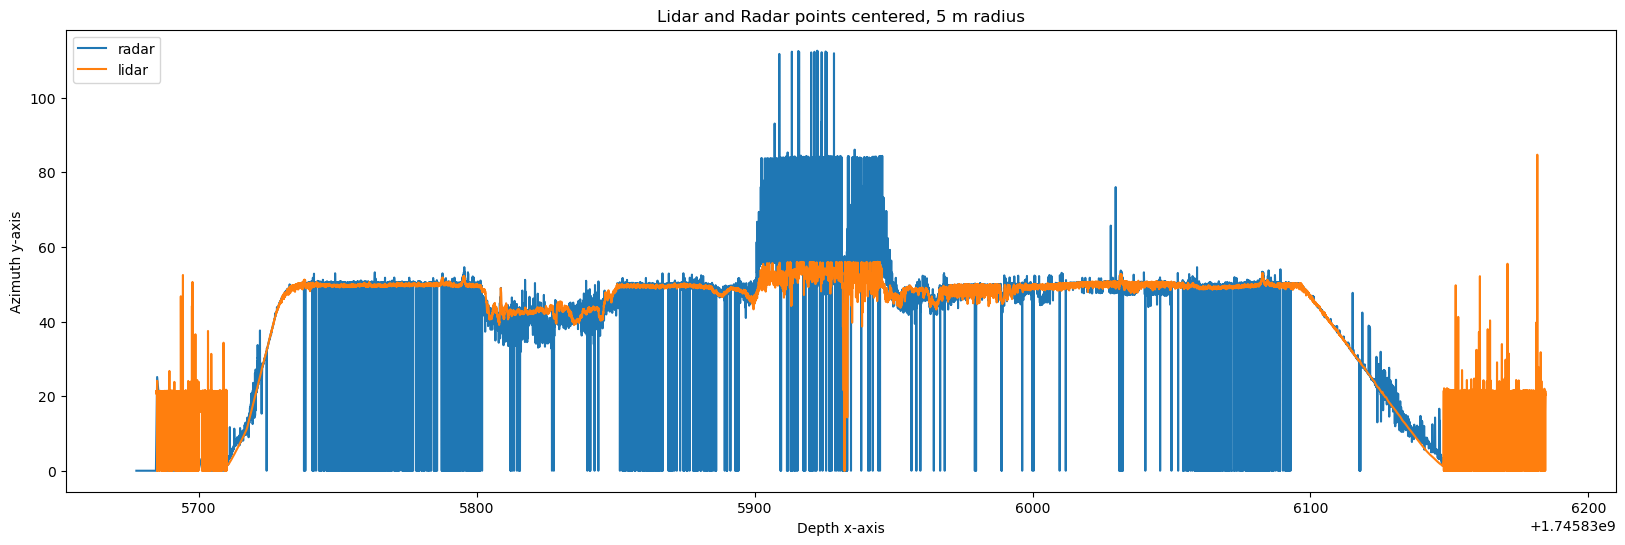

In [18]:
plt.figure(figsize=(20, 6))
plt.plot(radar_df['timestamp_sample'], radar_altitude, label='radar')
plt.plot(lidar_df['timestamp_sample'], lidar_altitude, label='lidar')
plt.title("Lidar and Radar points centered, 5 m radius")
plt.xlabel("Depth x-axis")
plt.ylabel("Azimuth y-axis")
plt.legend(loc="upper left") 
plt.show()

### Where do the static parts of the experiment take place?

In [ ]:

vel_df = get_velocity_df_from_db3_reader(db3_reader)
speed = get_speed_from_navsat_velocity_df(vel_df)

## get when the speed is low
timestamp_segments = []
low_limit = 0.5 # m/s

_ts_s, _ts_e = 0, 0
for i in range(speed.shape[0]):
    if (speed[i] < low_limit and _ts_s == 0):  # first ts with low speed
        _ts_s = vel_df['timestamp_sample'][i]
    if (speed[i] > low_limit and _ts_s != 0):  # over speed threshold, already have a starting point
        _ts_e = vel_df['timestamp_sample'][i-1]
        timestamp_segments.append([_ts_s, _ts_e])
        _ts_s, _ts_e = 0, 0

print("Segments found:", len(timestamp_segments))
for segment in timestamp_segments:
    print("Length segment in seconds:", segment[1]-segment[0])

Segments found: 11
Length segment in seconds: 53.406094789505005
Length segment in seconds: 14.601925373077393
Length segment in seconds: 3.203613042831421
Length segment in seconds: 0.39742112159729004
Length segment in seconds: 16.201497554779053
Length segment in seconds: 3.4051802158355713
Length segment in seconds: 14.394346475601196
Length segment in seconds: 16.59814190864563
Length segment in seconds: 16.206892728805542
Length segment in seconds: 0.0
Length segment in seconds: 17.597354888916016


In [ ]:
## show where we are in these segments | second try
navsat_df = get_navsat_df_from_db3_reader(db3_reader)
navsat_segments = []

m = 0   # to comare to
_s = -1
_e = -1
ts_seg = timestamp_segments[m]

for i in range(navsat_df.shape[0]):
    if (m < len(timestamp_segments)-1):
        ts = navsat_df['timestamp_sample'][i]
        if (ts >= ts_seg[0] and _s == -1):  # first time current ts is above the lower limit
            _s = i
        if (ts <= ts_seg[1]):
            _e = i
        if (ts > ts_seg[1]):
            navsat_segments.append([_s, _e])
            _s, _e = -1, -1
            m += 1
            ts_seg = timestamp_segments[m]

# navsat_df.shape
navsat_segments

[0, 266]
[441, 513]
[534, 549]
[630, 631]
[635, 715]
[782, 798]
[1164, 1235]
[1439, 1521]
[1653, 1733]
[1893, 1892]


[[0, 266],
 [441, 513],
 [534, 549],
 [630, 631],
 [635, 715],
 [782, 798],
 [1164, 1235],
 [1439, 1521],
 [1653, 1733],
 [1893, 1892]]

In [29]:
navsat_df = get_navsat_df_from_db3_reader(db3_reader)
print(navsat_df['timestamp_sample'][0])
print(vel_df['timestamp_sample'][0])

1745835684.533596
1745835684.5124614


1745835690.5227163 0.20565176010131836


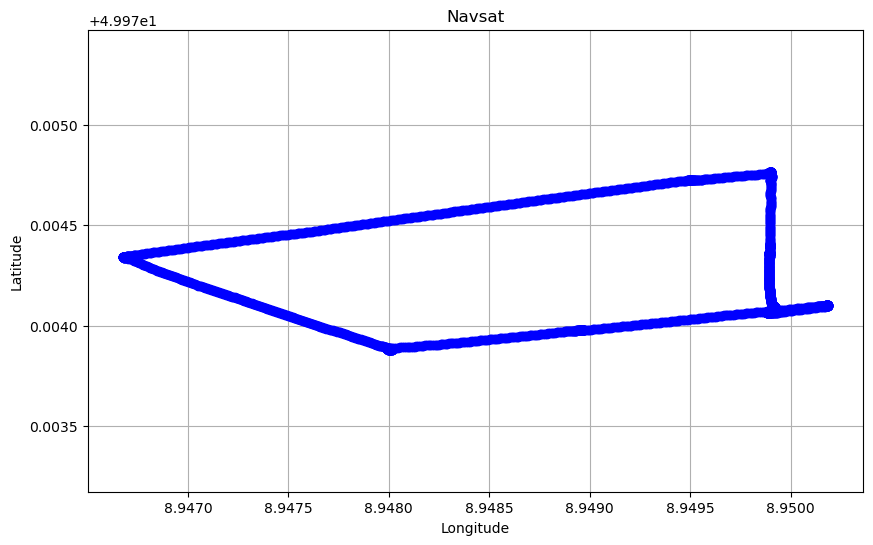

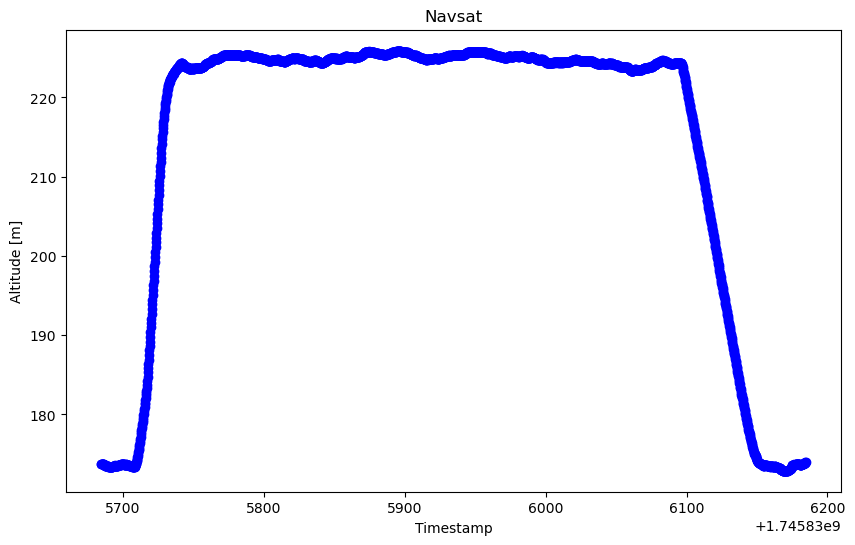

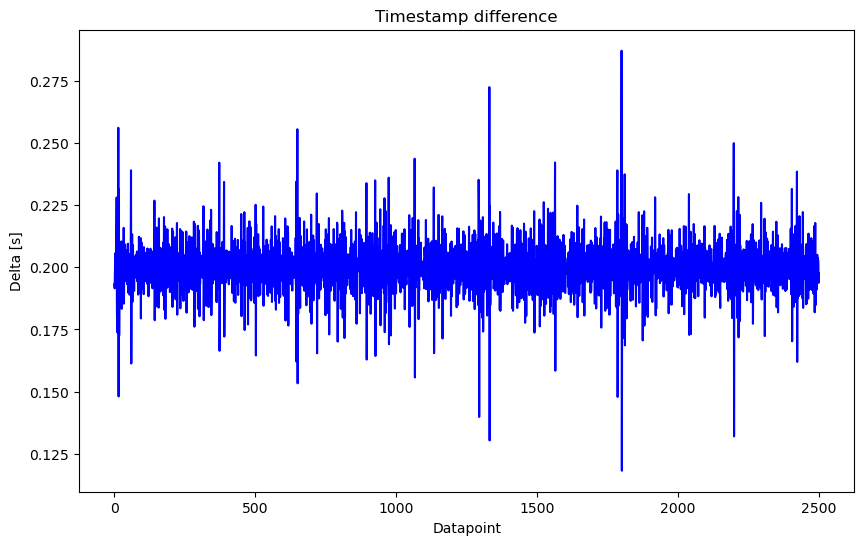

In [19]:
navsat_df = get_navsat_df_from_db3_reader(db3_reader)
plot_navsat_data_from_df(navsat_df)

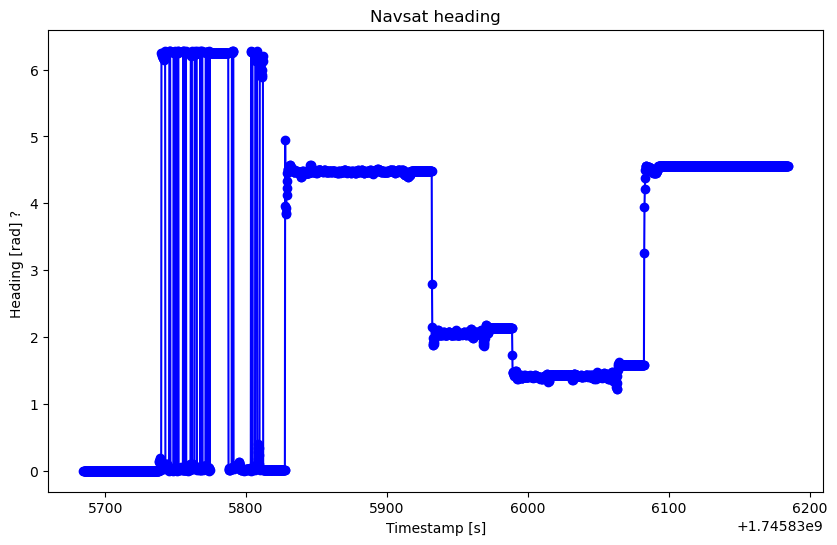

In [20]:
plot_navsat_heading_data_from_df(get_navsat_heading_df_from_db3_reader(db3_reader))

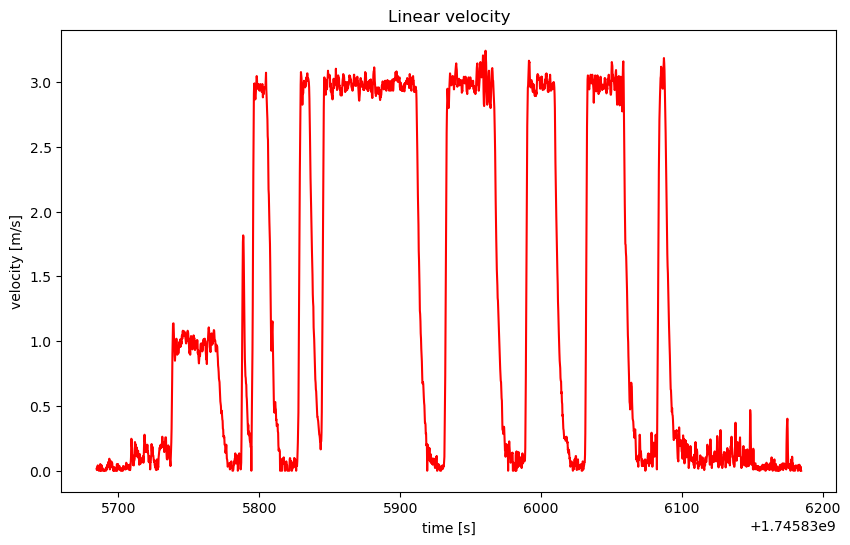

In [22]:
vel_df = get_velocity_df_from_db3_reader(db3_reader)
# plot_velocity_from_df(vel_df)

plot_speed_from_np(vel_df['timestamp_sample'], get_speed_from_navsat_velocity_df(vel_df))
plt.show()

In [ ]:
speed_array = get_speed_from_navsat_velocity_df(vel_df)